# Gene mutation analysis
## Load graph
Parsing GFA file manually, since GfaPy takes a strangely long amount of time reading through it.

In [1]:
import networkx as nx
import matplotlib
from matplotlib import pyplot
from statistics import median

# Loads the new graph
FILENAME = "/home/marcus/PevznerLabBigData/20201014_graph/noseq.gfa"

# We ignore directionality for right now
graph = nx.Graph()

with open(FILENAME, "r") as gfafile:
    for line in gfafile:
        if line[0] == "S":
            parts = line.strip().split("\t")
            node_name = parts[1]
            node_len = None
            node_cov = None
            extra_data = parts[3:]
            for tag in extra_data:
                if tag.startswith("LN:i:"):
                    if node_len is None:
                        node_len = int(tag[5:])
                    else:
                        raise ValueError("Duplicate length for node {}".format(node_name))
                elif tag.startswith("dp:i:"):
                    if node_cov is None:
                        node_cov = int(tag[5:])
                    else:
                        raise ValueError("Duplicate coverage for node {}".format(node_name))
            graph.add_node(node_name, length=node_len, cov=node_cov)
        elif line[0] == "L":
            parts = line.strip().split("\t")
            src = parts[1]
            snk = parts[3]
            # Ignore directionality for just right now; this means that some links will be "repeated" (for
            # the new graph this means that the NX representation has 484 less links)
            graph.add_edge(src, snk)

node2len = nx.get_node_attributes(graph, "length")
node2cov = nx.get_node_attributes(graph, "cov")
            
print("Graph contains {} edges (represented as GFA segments).".format(graph.number_of_nodes()))
print("Graph contains {} links between edges (ignoring directionality for now).".format(graph.number_of_edges()))
print("Graph contains {} connected components.".format(nx.number_connected_components(graph)))

Graph contains 36260 edges (represented as GFA segments).
Graph contains 40545 links between edges (ignoring directionality for now).
Graph contains 8655 connected components.


## Compute "real" coverage based on pileup data

Go through pileup for each of the edges, compute number of mapped reads at each position, and average over all positions in the sequence. Will be more accurate than the value reported in the graph, at least from the perspective of the data we're looking at.

In [92]:
from statistics import mean
from collections import defaultdict

edgenum2coverages = defaultdict(list)
with open("/home/marcus/PevznerLabBigData/20201014_graph/5xdata-pileup.txt", "r") as pf:
    for line in pf:
        split = line.split("\t")
        lineheader = split[0]
        edgenum = lineheader.split("_")[1]
        position_coverage = int(split[3])
        edgenum2coverages[edgenum].append(position_coverage)
        
for edge in edgenum2coverages:
    print("Edge {} (length {:,}): {:,} positions in pileup. Average coverage = {:.2f}. Median coverage = {}.".format(
        edge, node2len[edge], len(edgenum2coverages[edge]), mean(edgenum2coverages[edge]),
        median(edgenum2coverages[edge])
    ))

Edge 166 (length 1,302,342): 1,302,342 positions in pileup. Average coverage = 527.11. Median coverage = 527.0.
Edge 6018 (length 2,232,606): 2,232,606 positions in pileup. Average coverage = 515.58. Median coverage = 507.0.
Edge 7998 (length 1,634,900): 1,634,900 positions in pileup. Average coverage = 796.41. Median coverage = 786.0.


## Visualize mutation spectra

###  Visualizing raw number of discordant aligned reads

For each position in the sequence, find the number of matches (`.` or `,` characters) and return

\begin{equation}
\text{Number of aligned reads} - \text{Number of matching reads}
\end{equation}

In [10]:
from collections import defaultdict
edge2mutations = defaultdict(list)
edge2pos = defaultdict(list)
with open("/home/marcus/PevznerLabBigData/20201014_graph/5xdata-pileup.txt", "r") as pf:
    for line in pf:
        split = line.split("\t")
        lineheader = split[0]
        edgenum = lineheader.split("_")[1]
        num_matches = split[4].count(".") + split[4].count(",")
        edge2mutations[edgenum].append(int(split[3]) - num_matches)
        edge2pos[edgenum].append(int(split[1]))

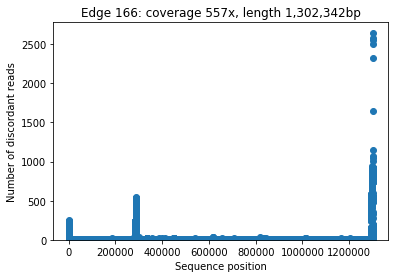

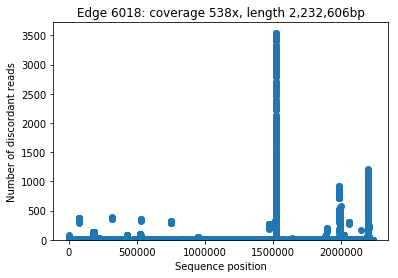

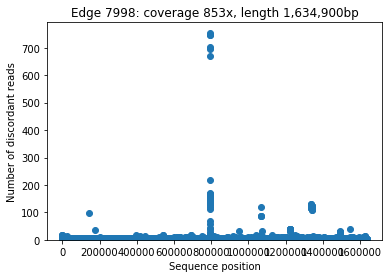

In [12]:
for e in edge2mutations.keys():
    pyplot.scatter(x=edge2pos[e], y=edge2mutations[e])
    pyplot.title("Edge {}: coverage {:,}x, length {:,}bp".format(e, node2cov[e], node2len[e]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of discordant reads")
    pyplot.ylim(bottom=0)
    pyplot.show()

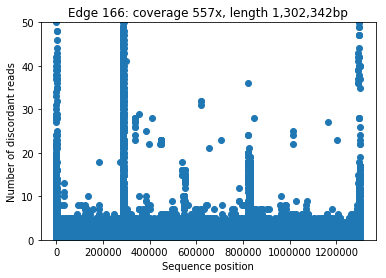

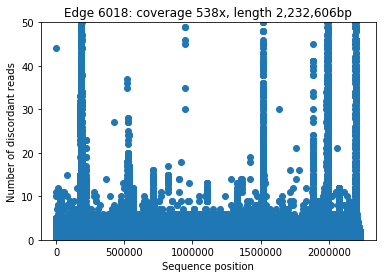

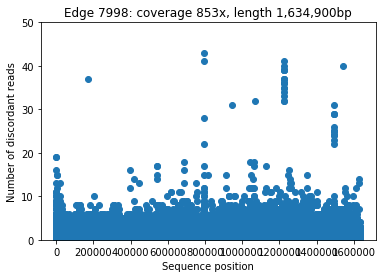

In [13]:
# Spectra but zoomed in to [0, 50]
for e in edge2mutations.keys():
    pyplot.scatter(x=edge2pos[e], y=edge2mutations[e])
    pyplot.title("Edge {}: coverage {:,}x, length {:,}bp".format(e, node2cov[e], node2len[e]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of discordant reads")
    pyplot.ylim(bottom=0, top=50)
    pyplot.show()

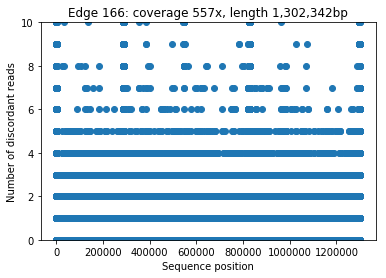

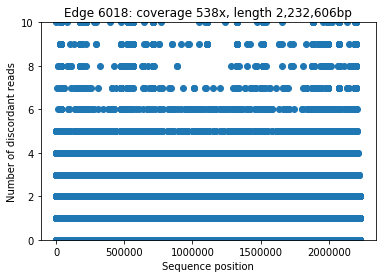

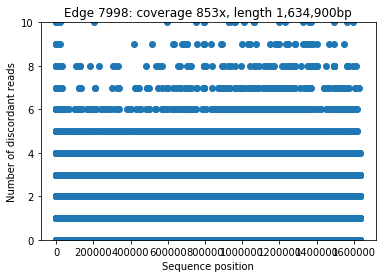

In [9]:
# Spectra but zoomed in to [0, 10]
for e in edge2mutations.keys():
    pyplot.scatter(x=edge2pos[e], y=edge2mutations[e])
    pyplot.title("Edge {}: coverage {:,}x, length {:,}bp".format(e, node2cov[e], node2len[e]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of discordant reads")
    pyplot.ylim(bottom=0, top=10)
    pyplot.show()

## Go through predicted genes and compute mutation frequencies at 1st, 2nd, 3rd positions

### Compute coverage and match frequency at every position
From these two values we can do quite a few different things -- there are many ways to define a "mutation" / "variant" / etc. Makes sense to load this stuff in all at once and then mess around with it afterwards, rather than repeatedly parsing the massive pileup file.

In [45]:
from collections import defaultdict
# "Coverage": number of reads aligning to this position
edge2pos2cov = defaultdict(dict)
# "Matches": number of matching reads (i.e. those matching the assembled sequence) at this position
edge2pos2matches = defaultdict(dict)
with open("/home/marcus/PevznerLabBigData/20201014_graph/5xdata-pileup.txt", "r") as pf:
    for line in pf:
        split = line.split("\t")
        lineheader = split[0]
        edgenum = lineheader.split("_")[1]
        num_matches = split[4].count(".") + split[4].count(",")
        
        # use 1-indexed coordinates, since MetaGeneMark and Prodigal do in their output.
        # Fortunately pileup also uses 1-indexed coordinates.
        # The reason we store this stuff in dicts of dicts (rather than just dicts of lists, where
        # the 0th entry is the 1st position, the 1st entry is the 2nd position, etc.) is because we don't
        # really need to save the memory right now, and I want to avoid off-by-1 errors as much as possible.
        pos = int(split[1])
        edge2pos2cov[edgenum][pos] = int(split[3])
        edge2pos2matches[edgenum][pos] = num_matches

### Quick check: how many genes, and how many bases within genes, are present in each of the three edges?
Assumes that genes are non-overlapping, which should be a safe assumption.

In [60]:
for edge in ["7998", "166", "6018"]:
    num_genes = 0
    bases_in_genes = 0
    mgm = pd.read_csv(
        "/home/marcus/PevznerLabBigData/20201014_graph/{}_mgm_genes.txt".format(edge),
        sep="\s+", skiprows=[1], index_col=0, header=0, names=["Strand", "LeftEnd", "RightEnd", "Length", "Class"]
    )
    for gene in mgm.itertuples():
        num_genes += 1
        bases_in_genes += len(get_pos_interval_from_gene(gene))
    print("Edge {}: {:,} genes, {:,} bases in genes".format(edge, num_genes, bases_in_genes))

Edge 7998: 1,651 genes, 1,504,125 bases in genes
Edge 166: 1,245 genes, 1,190,367 bases in genes
Edge 6018: 1,958 genes, 1,820,328 bases in genes


### Utility functions

In [77]:
import pandas as pd
from statistics import mean

def histogram_of_123(one, two, three, title, xlabel="Modulo position within gene", ylabel="Frequency"):
    pyplot.bar(x=[1, 2, 3], height=[one, two, three])
    pyplot.title(title)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.show()
    
def get_pos_interval_from_gene(gene):
    try:
        start = int(gene.LeftEnd)
    except ValueError:
        # Account for the "<2" left end coordinate in one of the genes predicted
        start = int(gene.LeftEnd[1:])
    end = int(gene.RightEnd)

    if gene.Strand == "-":
        return range(end, start - 1, -1)
    elif gene.Strand == "+":
        return range(start, end + 1)
    else:
        raise ValueError("Unknown strand: {}".format(gene.Strand))
        
def histogram_maker(pseudo_variant_caller, title, val_aggregator=sum, min_gene_length=0, ylabel="Frequency"):
    """
    Produces histograms of pileup data for the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    pseudo_variant_caller: function
        Takes as input two parameters:
            1. cov: an integer describing number of reads aligned to a position
            2. matches: an integer describing the number of matching reads aligned to a position
            
        Returns a number. For example, if we wanted to only count "mutations" as positions where 10% or more
        of the aligned reads didn't match, we could set a pseudo_variant_caller of
        lambda cov, matches: 1 if (matches / cov) <= 0.9 else 0 (assuming val_aggregator is left as sum).
        
    title: str
        Will be included after the edge name in every histogram.
        
    val_aggregator: function
        Used to aggregate the outputs of pseudo_variant_caller across all 1, 2, and 3 codon positions within
        all predicted genes for each edge. This defaults to the builtin sum function, which is useful if
        pseudo_variant_caller returns binary output (i.e. 0 or 1, as in the example given above); but other
        functions, such as statistics.mean or statistics.median, may be preferable depending on the context.
        
    min_gene_length: int
        All genes that are shorter than this will not be represented in the histograms. Defaults to 0, i.e.
        all genes are included. Note that this length is given in positions of DNA -- so if you want to only
        focus on genes with, say, at least 500 amino acids, then you should set min_gene_length to maybe somewhere
        around 1500 (I guess this depends on whether you count the start/stop codons as amino acids or not?).
        
    ylabel: str
        Label for the y-axis of the histogram. Defaults to "Frequency", but if you change val_aggregator then
        this should likely be changed as well.
    """
    for edge in ["7998", "166", "6018"]:
        mgm = pd.read_csv(
            "/home/marcus/PevznerLabBigData/20201014_graph/{}_mgm_genes.txt".format(edge),
            sep="\s+", skiprows=[1], index_col=0, header=0, names=["Strand", "LeftEnd", "RightEnd", "Length", "Class"]
        )

        # Mutation rates at modulo positions 1, 2, 3 in a gene within the genome (goes 1, 2, 3, 1, 2, 3, ...)
        m1 = []
        m2 = []
        m3 = []
        for gene in mgm.itertuples():
            if gene.Length < min_gene_length:
                # print("Gene {} has len {}, less than {}.".format(gene.Index, gene.Length, MIN_GENE_LENGTH))
                continue
            i = 1
            for pos in get_pos_interval_from_gene(gene):
                cov = edge2pos2cov[edge][pos]
                matches = edge2pos2matches[edge][pos]
                val = pseudo_variant_caller(cov, matches)
                if i == 1:
                    m1.append(val)
                    i = 2
                elif i == 2:
                    m2.append(val)
                    i = 3
                elif i == 3:
                    m3.append(val)
                    i = 1
                else:
                    raise ValueError("Marcus forgot how modulos work, go yell at him pls")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")
            
        if not (len(m1) == len(m2) == len(m3)):
            raise ValueError("Imbalance in 1/2/3 positions.")
        histogram_of_123(
            val_aggregator(m1), val_aggregator(m2), val_aggregator(m3),
            "Edge {}: {}".format(edge, title), ylabel=ylabel
        )

### Exactly 1 "mutation"

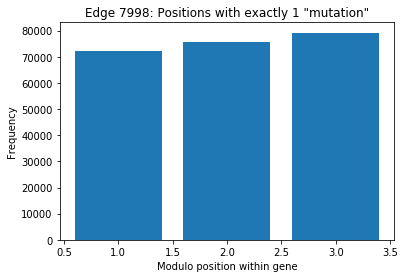

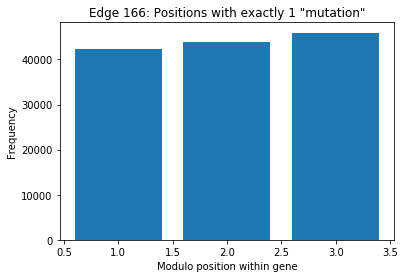

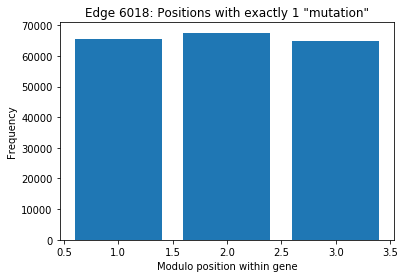

In [78]:
f = lambda cov, matches: 1 if matches == cov - 1 else 0
histogram_maker(f, 'Positions with exactly 1 "mutation"')

### Exactly 2 "mutations"

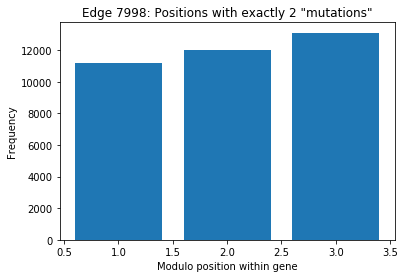

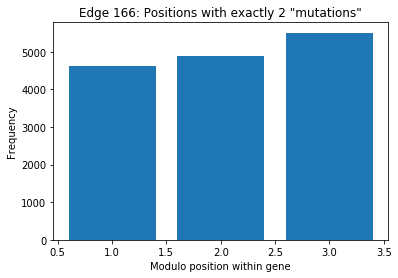

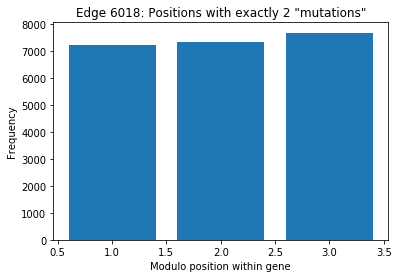

In [79]:
f = lambda cov, matches: 1 if matches == cov - 2 else 0
histogram_maker(f, 'Positions with exactly 2 "mutations"')

### Exactly 3 "mutations"

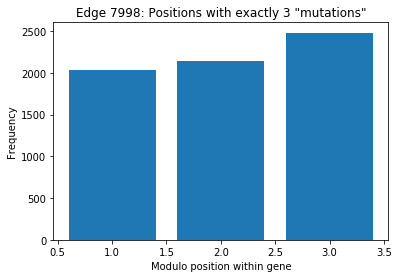

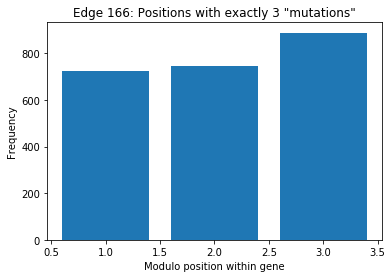

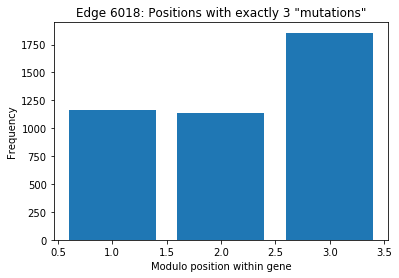

In [80]:
f = lambda cov, matches: 1 if matches == cov - 3 else 0
histogram_maker(f, 'Positions with exactly 3 "mutations"')

### At least one "mutation"

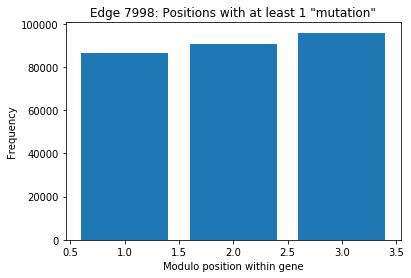

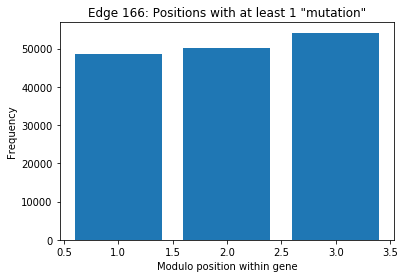

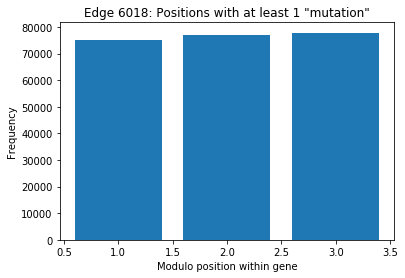

In [86]:
f = lambda cov, matches: 1 if matches < cov else 0
histogram_maker(f, 'Positions with at least 1 "mutation"')

### 10 or more "mutations"

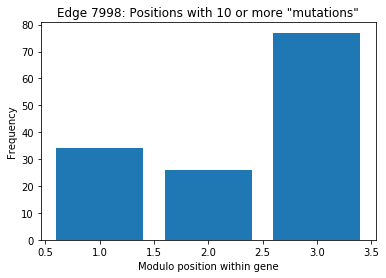

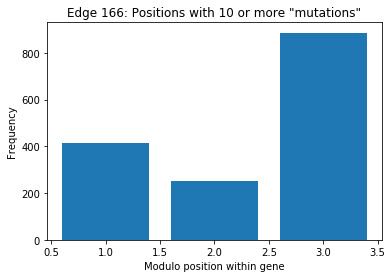

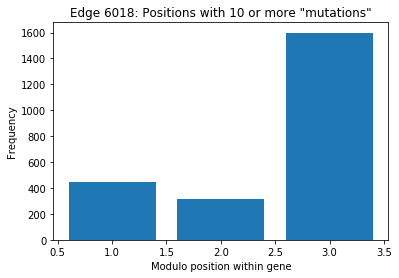

In [81]:
f = lambda cov, matches: 1 if matches <= cov - 10 else 0
histogram_maker(f, 'Positions with 10 or more "mutations"')

### 1% or more "mutations"

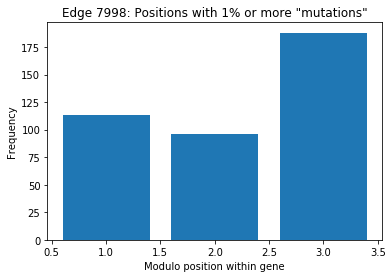

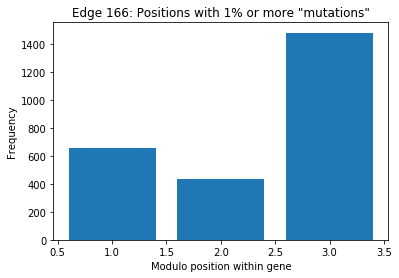

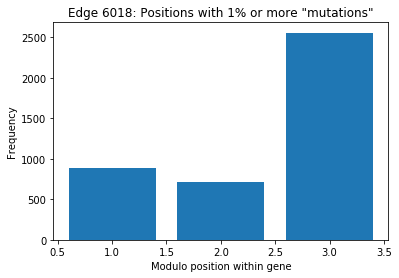

In [82]:
f = lambda cov, matches: 1 if 1 - (matches / cov) >= 0.01 else 0
histogram_maker(f, 'Positions with 1% or more "mutations"')

### 1% or more "mutations", min gene length of 1500 bp

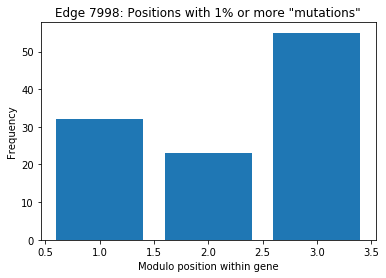

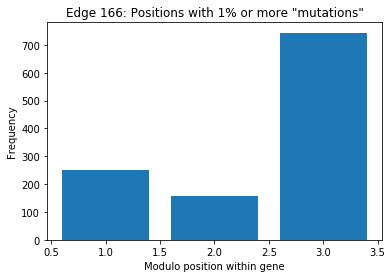

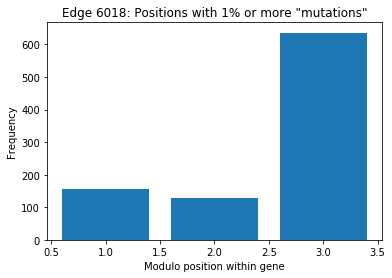

In [90]:
f = lambda cov, matches: 1 if 1 - (matches / cov) >= 0.01 else 0
histogram_maker(f, 'Positions with 1% or more "mutations"', min_gene_length=1500)

### 10% or more "mutations"

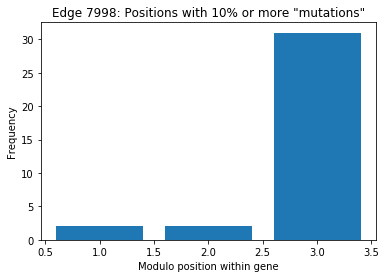

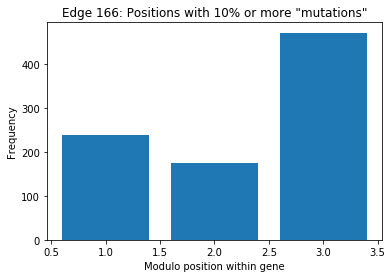

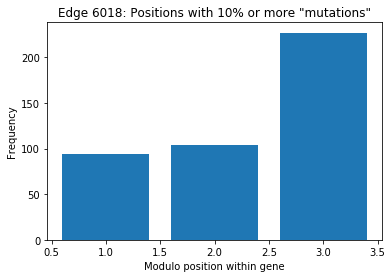

In [83]:
f = lambda cov, matches: 1 if 1 - (matches / cov) >= 0.1 else 0
histogram_maker(f, 'Positions with 10% or more "mutations"')

### 50% or more "mutations"

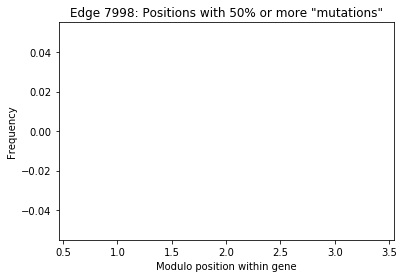

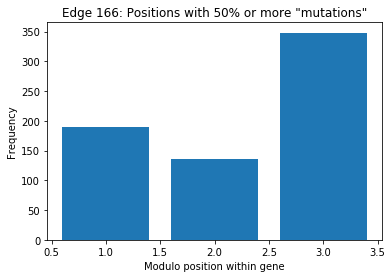

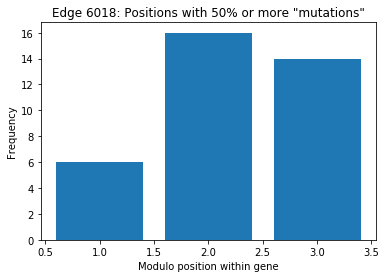

In [84]:
f = lambda cov, matches: 1 if 1 - (matches / cov) >= 0.5 else 0
histogram_maker(f, 'Positions with 50% or more "mutations"')

### Average mutation rate

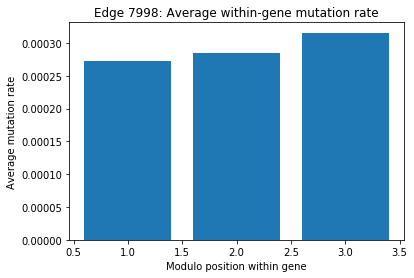

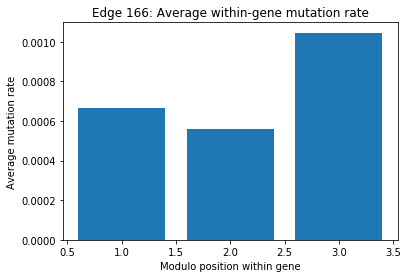

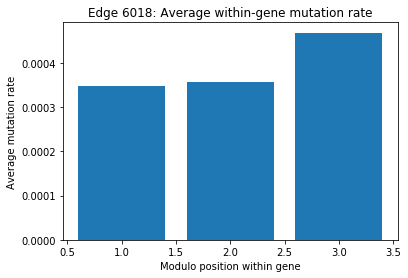

In [91]:
f = lambda cov, matches: 1 - (matches / cov)
histogram_maker(f, "Average within-gene mutation rate", val_aggregator=mean, ylabel="Average mutation rate")